In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [2]:
# Step 1: Data Loading
file_paths = ["Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
              "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
              "Friday-WorkingHours-Morning.pcap_ISCX.csv",
              "Monday-WorkingHours.pcap_ISCX.csv",
              "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
              "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
              "Tuesday-WorkingHours.pcap_ISCX.csv",
              "Wednesday-workingHours.pcap_ISCX.csv"]


In [3]:
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate individual dataframes into one
combined_df = pd.concat(dfs)

In [4]:
# Replace infinity or very large values with NaN
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Check for missing values after replacing infinity or very large values
print(combined_df.isnull().sum())
# Drop rows with missing values
combined_df.dropna(inplace=True)
# Description of Data:
describe_info = combined_df.describe()

# Identification of All Zero Columns:
all_zeroes_cols = describe_info.loc[:,(describe_info.iloc[1:] == 0).all()]

# Dropping All Zero Columns:
combined_df.drop(columns=all_zeroes_cols, inplace=True)

# Checking Resulting DataFrame's Validity:
combined_df.shape  # check if resulting DataFrame valid



 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64


(2827876, 71)

In [5]:
# Check the data types of all columns
data_types = combined_df.dtypes
print(data_types)


 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 71, dtype: object


In [6]:
# Replace non-printable characters and strip leading/trailing spaces

combined_df.loc[:," Label"].replace({"Web Attack � XSS" : "XSS", "Web Attack � Sql Injection": "Sql Injection", "Web Attack � Brute Force": "Brute Force"}, inplace=True)
# Print unique values after cleaning
combined_df[' Label'].unique()



array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration', 'Brute Force',
       'XSS', 'Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [7]:
combined_df

Destination Port   Flow Duration   Total Fwd Packets  \
0                   54865               3                   2   
1                   55054             109                   1   
2                   55055              52                   1   
3                   46236              34                   1   
4                   54863               3                   2   
...                   ...             ...                 ...   
692698                 53           32215                   4   
692699                 53             324                   2   
692700              58030              82                   2   
692701                 53         1048635                   6   
692702                 53           94939                   4   

         Total Backward Packets  Total Length of Fwd Packets  \
0                             0                           12   
1                             1                            6   
2                             1                            6   
3                             1                            6   
4                             0                           12   
...                         ...                          ...   
692698                        2                          112   
692699                        2                           84   
692700                        1                           31   
692701                        2                          192   
692702                        2                          188   

         Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                  0                       6   
1                                  6                       6   
2                                  6                       6   
3                                  6                       6   
4                                  0                       6   
...                              ...                     ...   
692698                           152                      28   
692699                           362                      42   
692700                             6                      31   
692701                           256                      32   
692702                           226                      47   

         Fwd Packet Length Min   Fwd Packet Length Mean  \
0                            6                      6.0   
1                            6                      6.0   
2                            6                      6.0   
3                            6                      6.0   
4                            6                      6.0   
...                        ...                      ...   
692698                      28                     28.0   
692699                      42                     42.0   
692700                       0                     15.5   
692701                      32                     32.0   
692702                      47                     47.0   

         Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                      0.00000  ...                     20          0.0   
1                      0.00000  ...                     20          0.0   
2                      0.00000  ...                     20          0.0   
3                      0.00000  ...                     20          0.0   
4                      0.00000  ...                     20          0.0   
...                        ...  ...                    ...          ...   
692698                 0.00000  ...                     20          0.0   
692699                 0.00000  ...                     20          0.0   
692700                21.92031  ...                     32          0.0   
692701                 0.00000  ...                     20          0.0   
692702                 0.00000  ...                     20          0.0   

         Active Std   Active Max   Active Min  Idle Mean   Idle Std  \
0        

## Outliers

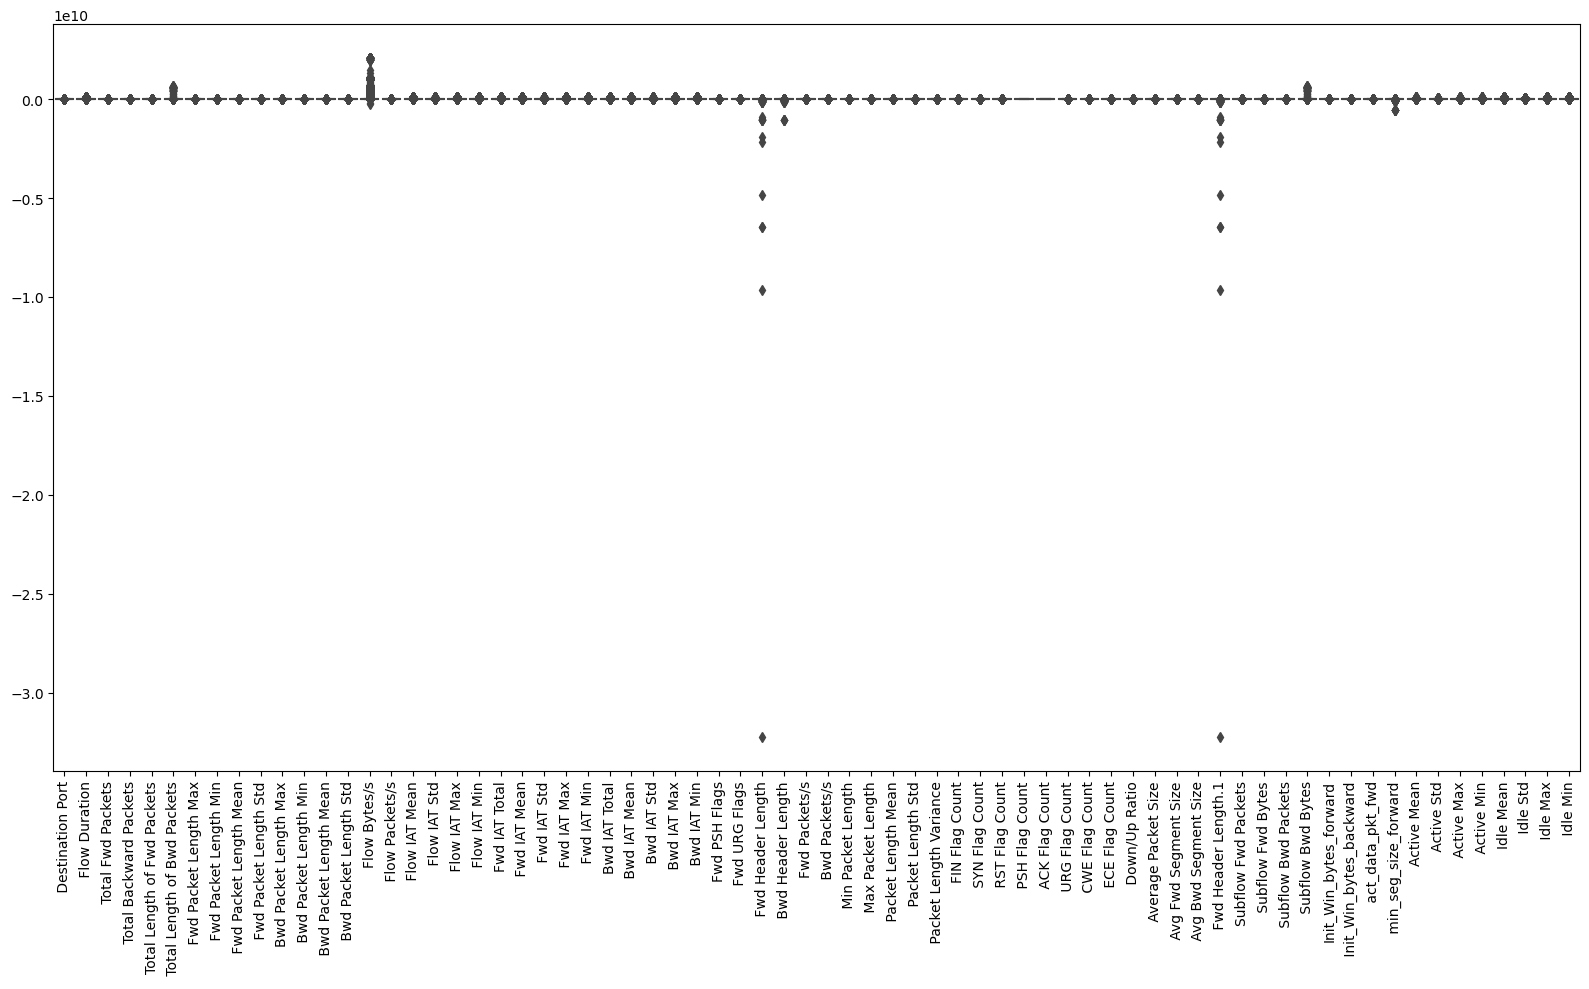

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot boxplots for numerical features
plt.figure(figsize=(16, 10))  # Increase figure size
sns.boxplot(data=combined_df)
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Save the plot to a file with adjusted dimensions
plt.tight_layout()  # Adjust layout to fit labels
plt.savefig('outlier.png', dpi=300)  # Increase resolution if needed

plt.show()

# Calculate z-scores for each numerical feature
from scipy import stats

z_scores = stats.zscore(combined_df.select_dtypes(include=np.number))

# Threshold for identifying outliers (e.g., z-score > 3)
threshold = 3

# Create a boolean mask to identify outliers
outlier_mask = np.abs(z_scores) > threshold

# Filter out outliers from the DataFrame
cleaned_df = combined_df[~outlier_mask.any(axis=1)]


In [10]:
cleaned_df

Destination Port   Flow Duration   Total Fwd Packets  \
0                   54865               3                   2   
4                   54863               3                   2   
5                   54871            1022                   2   
6                   54925               4                   2   
7                   54925              42                   1   
...                   ...             ...                 ...   
692696                 80        11512230                   5   
692698                 53           32215                   4   
692699                 53             324                   2   
692701                 53         1048635                   6   
692702                 53           94939                   4   

         Total Backward Packets  Total Length of Fwd Packets  \
0                             0                           12   
4                             0                           12   
5                             0                           12   
6                             0                           12   
7                             1                            6   
...                         ...                          ...   
692696                        5                          672   
692698                        2                          112   
692699                        2                           84   
692701                        2                          192   
692702                        2                          188   

         Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                  0                       6   
4                                  0                       6   
5                                  0                       6   
6                                  0                       6   
7                                  6                       6   
...                              ...                     ...   
692696                          3525                     672   
692698                           152                      28   
692699                           362                      42   
692701                           256                      32   
692702                           226                      47   

         Fwd Packet Length Min   Fwd Packet Length Mean  \
0                            6                      6.0   
4                            6                      6.0   
5                            6                      6.0   
6                            6                      6.0   
7                            6                      6.0   
...                        ...                      ...   
692696                       0                    134.4   
692698                      28                     28.0   
692699                      42                     42.0   
692701                      32                     32.0   
692702                      47                     47.0   

         Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                     0.000000  ...                     20          0.0   
4                     0.000000  ...                     20          0.0   
5                     0.000000  ...                     20          0.0   
6                     0.000000  ...                     20          0.0   
7                     0.000000  ...                     20          0.0   
...                        ...  ...                    ...          ...   
692696              300.527536  ...                     32        821.0   
692698                0.000000  ...                     20          0.0   
692699                0.000000  ...                     20          0.0   
692701                0.000000  ...                     20          0.0   
692702                0.000000  ...                     20          0.0   

         Active Std   Active Max   Active Min  Idle Mean   Idle Std  \
0        

## Normalization

In [11]:

xdf =cleaned_df.drop(' Label', axis=1)
ydf =cleaned_df[" Label"]

# Get the column names before MinMax normalization
column_names = xdf.columns

from tensorflow.keras import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

dense_array = xdf.astype('int16').values

# Now you can use 'dense_array' where dense data is required
scaler = MinMaxScaler()
# Apply MinMaxScaler directly to the numeric DataFrame
xdf = scaler.fit_transform(dense_array)


## Balancing

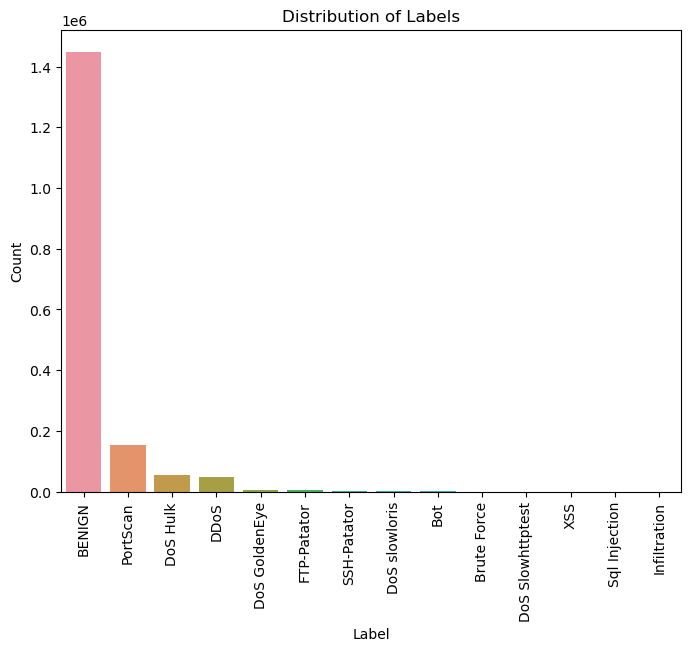

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each label
label_counts = ydf.value_counts()

# Visualize label distribution
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')

# Rotate labels vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

# Save the figure
plt.savefig('before_balancing_label_distribution.png', bbox_inches='tight')

# Show the plot
plt.show()


In [13]:
ydf.unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration', 'Brute Force',
       'XSS', 'Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye'],
      dtype=object)

In [14]:

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Print class distribution before balancing
class_distribution_before = ydf.value_counts()
print("Class Distribution before balancing:")
print(class_distribution_before)

# Remove classes with too few samples (for example, less than 5 samples)
min_samples_threshold = 5
filtered_classes = class_distribution_before[class_distribution_before >= min_samples_threshold].index
xdf_filtered = xdf[ydf.isin(filtered_classes)]
ydf_filtered = ydf[ydf.isin(filtered_classes)]

# Print the filtered class distribution
print("Class Distribution after filtering:")
print(ydf_filtered.value_counts())

# Determine the minimum number of samples across all remaining classes for under-sampling
min_samples = ydf_filtered.value_counts().min()

# Adjust the sampling_strategy for RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy={class_label: min_samples for class_label in ydf_filtered.unique()}, random_state=42)

# Create a reasonable sampling strategy for SMOTE based on existing classes
smote_sampling_strategy = {class_label: 10000 for class_label in ydf_filtered.unique()}

# Reduce the k_neighbors parameter for SMOTE to 1 for classes with less than 6 samples
smote = SMOTE(sampling_strategy=smote_sampling_strategy, k_neighbors=1, random_state=42)

# Define the pipeline
pipeline = Pipeline([('undersample', rus), ('oversample', smote)])

# Apply the pipeline to your filtered data
xdf_balanced, ydf_balanced = pipeline.fit_resample(xdf_filtered, ydf_filtered)

# Check the class distribution after balancing
class_distribution_after = ydf_balanced.value_counts()
print("\nClass Distribution after balancing:")
print(class_distribution_after)


Class Distribution before balancing:
 Label
BENIGN              1449176
PortScan             153457
DoS Hulk              55222
DDoS                  49163
DoS GoldenEye          4518
FTP-Patator            3984
SSH-Patator            2986
DoS slowloris          1840
Bot                    1191
Brute Force              78
DoS Slowhttptest         24
XSS                      23
Sql Injection            12
Infiltration              4
Name: count, dtype: int64
Class Distribution after filtering:
 Label
BENIGN              1449176
PortScan             153457
DoS Hulk              55222
DDoS                  49163
DoS GoldenEye          4518
FTP-Patator            3984
SSH-Patator            2986
DoS slowloris          1840
Bot                    1191
Brute Force              78
DoS Slowhttptest         24
XSS                      23
Sql Injection            12
Name: count, dtype: int64

Class Distribution after balancing:
 Label
BENIGN              10000
Bot                 10000
Brute For

In [15]:
# Check the shape of the balanced dataset
print("Shape of balanced dataset:", xdf_balanced.shape, ydf_balanced.shape)


Shape of balanced dataset: (130000, 70) (130000,)


In [16]:
# Check the shape of the balanced dataset
print("Shape of imbalanced dataset:", xdf.shape, ydf.shape)


Shape of imbalanced dataset: (1721678, 70) (1721678,)


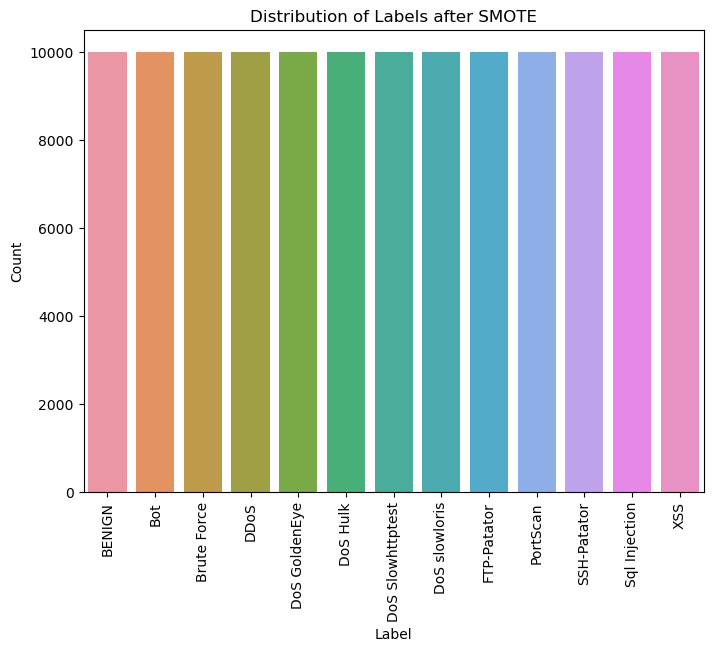

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each label
label_counts = ydf_balanced.value_counts()

# Visualize label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels after SMOTE')
plt.xlabel('Label')
plt.ylabel('Count')

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Save the figure
plt.savefig('after_balancing_label_distribution.png', bbox_inches='tight')

# Show the plot
plt.show()


In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(xdf_balanced, ydf_balanced, test_size=0.3, random_state=42)


## Feature Selection RandomForest

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Perform k-fold cross-validation with k = 5
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)


Cross-validation scores: [0.99994505 0.99989011 1.         1.         0.99994505]


In [20]:
# Fit the Random Forest classifier on the training data
rf_classifier.fit(X_train, y_train)


RandomForestClassifier()

In [21]:
from sklearn.metrics import accuracy_score, classification_report

# Predict labels for the test set
y_pred = rf_classifier.predict(X_test)



In [22]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Rank the importance of features
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = column_names[sorted_indices]

# Print feature importance rankings
print("Feature Importance Rankings:")
for i, feature in enumerate(sorted_features):
    print(f"{i+1}. {feature}: {feature_importances[sorted_indices[i]]}")


Feature Importance Rankings:
1.  Destination Port: 0.0464687275341402
2.  Total Fwd Packets: 0.038077125384530265
3. Subflow Fwd Packets: 0.03609586798584648
4. Init_Win_bytes_forward: 0.03516348858223854
5.  Fwd Header Length: 0.034691312416587204
6.  min_seg_size_forward: 0.03167349136315404
7.  Subflow Bwd Packets: 0.031014057814717572
8.  act_data_pkt_fwd: 0.029869692460972697
9.  Bwd Packet Length Mean: 0.02986870630314572
10.  Fwd IAT Min: 0.029858763813274267
11.  Fwd Header Length.1: 0.029774999056941226
12.  Fwd Packet Length Max: 0.029057987690549396
13.  Subflow Bwd Bytes: 0.02731500647138645
14.  Bwd Header Length: 0.023654530563853277
15.  Average Packet Size: 0.02347637451680005
16.  Total Backward Packets: 0.023147861634378465
17. Bwd Packet Length Max: 0.022776588651235247
18.  Fwd Packet Length Std: 0.02222963994781448
19.  Flow IAT Max: 0.021711552155205937
20.  Packet Length Mean: 0.021347042937012457
21.  Total Length of Bwd Packets: 0.021016431628819457
22.  ACK Fl

In [23]:
# Print selected feature names based on ranking
print("Selected Feature (RF) Names Based on Ranking:")
for i, feature_name in enumerate(sorted_features[:10], start=1):
    print(f"{i}. {feature_name}")


Selected Feature (RF) Names Based on Ranking:
1.  Destination Port
2.  Total Fwd Packets
3. Subflow Fwd Packets
4. Init_Win_bytes_forward
5.  Fwd Header Length
6.  min_seg_size_forward
7.  Subflow Bwd Packets
8.  act_data_pkt_fwd
9.  Bwd Packet Length Mean
10.  Fwd IAT Min


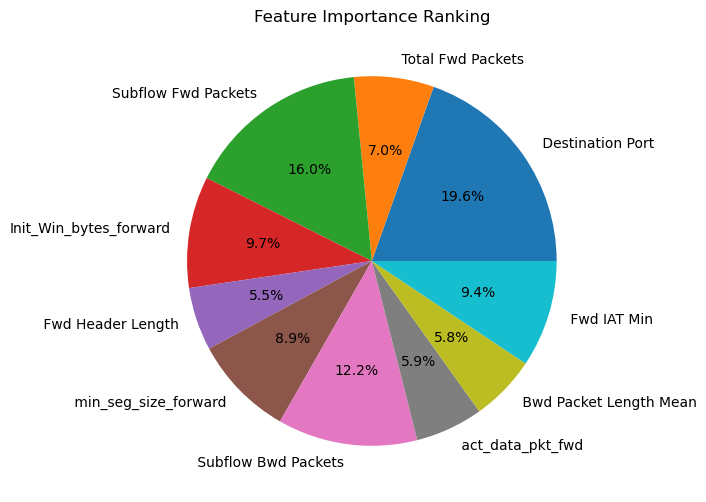

In [24]:
import matplotlib.pyplot as plt

# Get the top 10 feature names and their importance values
top_features_rf_names = sorted_features[:10]
top_features_rf_importance = feature_importances[:10]

# Plot a pie chart for feature importance
plt.figure(figsize=(7, 6))
plt.pie(top_features_rf_importance, labels=top_features_rf_names, autopct='%1.1f%%')
plt.title('Feature Importance Ranking')

# Save the plot to a file
plt.savefig('Featur_Importance.png')

plt.show()


# Random Forest

In [25]:
# Select the top 10 features based on importance

top_features = sorted_features[:10]

# Filter the training and testing data to include only the top features
X_train_top = X_train[:, sorted_indices[:10]]
X_test_top = X_test[:, sorted_indices[:10]]

# Initialize the Random Forest classifier
rf_classifier_top = RandomForestClassifier(random_state=42)

# Perform k-fold cross-validation with k = 5
cv_scores_top = cross_val_score(rf_classifier_top, X_train_top, y_train, cv=5)

# Print the cross-validation scores for the top features
print("Cross-validation scores with top 10 features:", cv_scores_top)

# Fit the Random Forest classifier on the training data with top features
rf_classifier_top.fit(X_train_top, y_train)

# Predict labels for the test set with top features
y_pred_top = rf_classifier_top.predict(X_test_top)

# Calculate accuracy score with top features
accuracy_top = accuracy_score(y_test, y_pred_top)
print("Accuracy with top 10 features:", accuracy_top)

# Generate classification report with top features
print("Classification Report with top 10 features:")
print(classification_report(y_test, y_pred_top))


Cross-validation scores with top 10 features: [0.9856044  0.98521978 0.98483516 0.98456044 0.98554945]
Accuracy with top 10 features: 0.9846153846153847
Classification Report with top 10 features:
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00      3009
             Bot       1.00      1.00      1.00      2994
     Brute Force       1.00      1.00      1.00      2967
            DDoS       1.00      1.00      1.00      3051
   DoS GoldenEye       1.00      1.00      1.00      3083
        DoS Hulk       1.00      1.00      1.00      2968
DoS Slowhttptest       0.91      0.89      0.90      3028
   DoS slowloris       0.89      0.91      0.90      3015
     FTP-Patator       1.00      1.00      1.00      2920
        PortScan       1.00      1.00      1.00      3104
     SSH-Patator       1.00      1.00      1.00      2957
   Sql Injection       1.00      1.00      1.00      2928
             XSS       1.00      1.00      1.00 

In [26]:
from sklearn.metrics import classification_report

# Generate classification report with top features
report = classification_report(y_test, y_pred_top, target_names=rf_classifier_top.classes_, output_dict=True)

# Print total accuracy, precision, recall, and F1-score
print("Total Accuracy:", report['accuracy'])
print("Total Precision:", report['macro avg']['precision'])
print("Total Recall:", report['macro avg']['recall'])
print("Total F1-Score:", report['macro avg']['f1-score'])


Total Accuracy: 0.9846153846153847
Total Precision: 0.9847375577736179
Total Recall: 0.9847273051131565
Total F1-Score: 0.9847244009431454


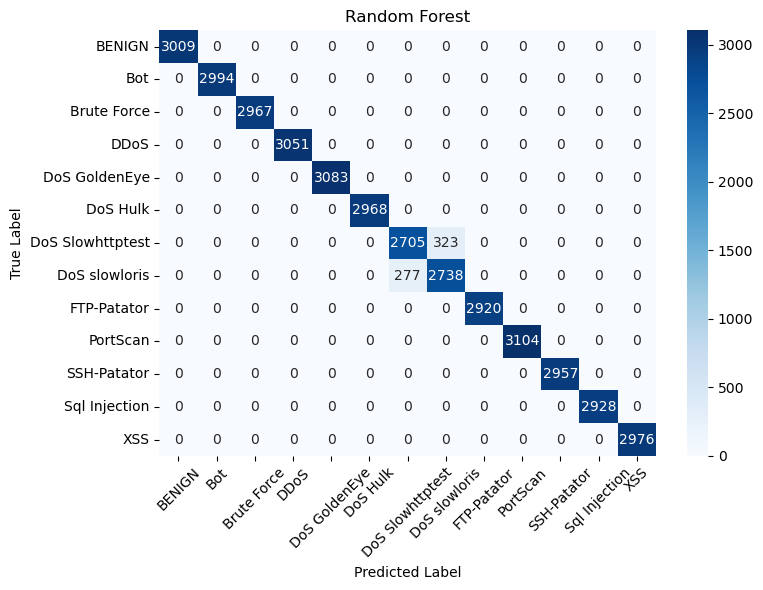

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_top)

# Plot confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_classifier_top.classes_, 
            yticklabels=rf_classifier_top.classes_)
plt.title('Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot for Random Forest
plt.savefig('RF_confusion_matrix.png')

# Show plot for Random Forest
plt.show()


In [28]:
# Select the index of the instance you want to check
instance_index = 2  # Change this index to the instance you want to check

# Get the features and actual label of the instance
instance_features = X_test_top[instance_index].reshape(1, -1)
actual_label = y_test.iloc[instance_index]

# Predict the label for the instance using the trained model
predicted_label = rf_classifier_top.predict(instance_features)[0]

# Check if the predicted label matches the actual label
prediction_correct = predicted_label == actual_label

# Print the result
if prediction_correct:
    print("Prediction is correct for instance", instance_index)
    print("Actual label:", actual_label)
    print("Predicted label:", predicted_label)
else:
    print("Prediction is incorrect for instance", instance_index)
    print("Actual label:", actual_label)
    print("Predicted label:", predicted_label)


Prediction is correct for instance 2
Actual label: BENIGN
Predicted label: BENIGN


In [29]:
import lime
import lime.lime_tabular
# Initialize the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_top,
    feature_names=top_features,
    class_names=['BENIGN', 'DDOS'],  # Adjust the class names as per your labels
    discretize_continuous=True
)
observation_id = 1  # Adjust this to the specific ID you want to explain
observation = X_test_top[observation_id].reshape(1, -1)
# Explain the model's prediction on the selected instance
explanation = explainer.explain_instance(
    observation.flatten(),  # The instance to explain
    rf_classifier_top.predict_proba,  # The prediction function
    num_features=10  # Number of features to show in explanation
)
# Show the explanation in the notebook
explanation.show_in_notebook(show_table=True, show_all=False)


# DecisionTreeClassifier

In [30]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the Decision Tree classifier on the training data
dt_classifier.fit(X_train_top, y_train)

# Predict labels for the test set using the trained Decision Tree classifier
y_pred_dt = dt_classifier.predict(X_test_top)

# Calculate accuracy score
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy with Decision Tree:", accuracy_dt)

# Generate classification report for the Decision Tree classifier
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))


Accuracy with Decision Tree: 0.9841538461538462
Classification Report for Decision Tree:
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00      3009
             Bot       1.00      1.00      1.00      2994
     Brute Force       1.00      1.00      1.00      2967
            DDoS       1.00      1.00      1.00      3051
   DoS GoldenEye       1.00      1.00      1.00      3083
        DoS Hulk       1.00      1.00      1.00      2968
DoS Slowhttptest       0.90      0.90      0.90      3028
   DoS slowloris       0.90      0.90      0.90      3015
     FTP-Patator       1.00      1.00      1.00      2920
        PortScan       1.00      1.00      1.00      3104
     SSH-Patator       1.00      1.00      1.00      2957
   Sql Injection       1.00      1.00      1.00      2928
             XSS       1.00      1.00      1.00      2976

        accuracy                           0.98     39000
       macro avg       0.98      0.98  

In [31]:
from sklearn.metrics import classification_report

# Generate classification report with top features
dt_report = classification_report(y_test, y_pred_dt, target_names=dt_classifier.classes_, output_dict=True)

# Print total accuracy, precision, recall, and F1-score
print("Total Accuracy:", dt_report['accuracy'])
print("Total Precision:", dt_report['macro avg']['precision'])
print("Total Recall:", dt_report['macro avg']['recall'])
print("Total F1-Score:", dt_report['macro avg']['f1-score'])


Total Accuracy: 0.9841538461538462
Total Precision: 0.9842674663234235
Total Recall: 0.9842673547726737
Total F1-Score: 0.9842663130145155


In [32]:
import numpy as np

# Select the index of the instance you want to check
dt_instance_index = 0  # Change this index to the instance you want to check

# Get the features and actual label of the instance
dt_instance_features = np.expand_dims(X_test_top[dt_instance_index], axis=0)
dt_actual_label = y_test.iloc[dt_instance_index]

# Predict the label for the instance using the trained model
dt_predicted_label = dt_classifier.predict(dt_instance_features)[0]

# Check if the predicted label matches the actual label
dt_prediction_correct = dt_predicted_label == dt_actual_label

# Print the result
if dt_prediction_correct:
    print("Prediction is correct for instance", dt_instance_index)
    print("Actual label:", dt_actual_label)
    print("Predicted label:", dt_predicted_label)
else:
    print("Prediction is incorrect for instance", dt_instance_index)
    print("Actual label:", dt_actual_label)
    print("Predicted label:", dt_predicted_label)


Prediction is correct for instance 0
Actual label: DoS Slowhttptest
Predicted label: DoS Slowhttptest


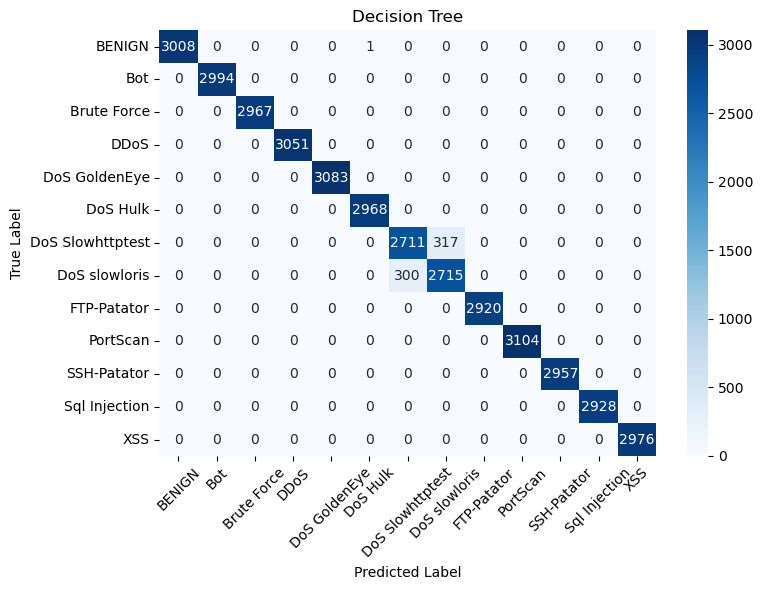

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique class labels
classes = np.unique(y_test)

# Calculate confusion matrix for Decision Tree
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, 
            yticklabels=classes)
plt.title('Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot for Decision Tree
plt.savefig('DT_confusion_matrix.png')

# Show plot for Decision Tree
plt.show()


In [34]:
import lime
import lime.lime_tabular

# Initialize the LIME explainer for Decision Tree
dt_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_top,  # Training data with top features for Decision Tree
    feature_names=top_features,  # Top feature names for Decision Tree
    class_names=['BENIGN', 'DDOS'],  # Class names (adjust as per your labels)
    discretize_continuous=True  # Discretize continuous features
)

# Select the observation ID you want to explain for Decision Tree
dt_observation_id = 1  # Adjust this to the specific ID you want to explain

# Get the observation to explain for Decision Tree
dt_observation = X_test_top[dt_observation_id].reshape(1, -1)

# Explain the model's prediction on the selected instance for Decision Tree
dt_explanation = dt_explainer.explain_instance(
    dt_observation.flatten(),  # Instance to explain
    dt_classifier.predict_proba,  # Prediction function (Decision Tree)
    num_features=10  # Number of features to show in explanation
)

# Show the explanation in the notebook for Decision Tree
dt_explanation.show_in_notebook(show_table=True, show_all=False)



# SVM classifier

In [35]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)  # You can adjust kernel and C parameter as needed

# Train the SVM classifier on the training data
svm_classifier.fit(X_train_top, y_train)

# Predict labels for the test set using the trained SVM classifier
y_pred_svm = svm_classifier.predict(X_test_top)

# Calculate accuracy score
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy with SVM:", accuracy_svm)

# Generate classification report for the SVM classifier
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))


Accuracy with SVM: 0.8436410256410256
Classification Report for SVM:


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

          BENIGN       1.00      0.86      0.92      3009
             Bot       0.97      1.00      0.99      2994
     Brute Force       0.86      1.00      0.92      2967
            DDoS       0.98      1.00      0.99      3051
   DoS GoldenEye       0.79      0.94      0.86      3083
        DoS Hulk       0.97      1.00      0.99      2968
DoS Slowhttptest       0.00      0.00      0.00      3028
   DoS slowloris       0.56      0.81      0.66      3015
     FTP-Patator       0.83      1.00      0.90      2920
        PortScan       0.97      1.00      0.98      3104
     SSH-Patator       1.00      0.99      1.00      2957
   Sql Injection       0.48      0.61      0.54      2928
             XSS       0.99      0.75      0.85      2976

        accuracy                           0.84     39000
       macro avg       0.80      0.84      0.82     39000
    weighted avg       0.80      0.84      0.82     39000



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
# Select the index of the instance you want to check
svm_instance_index = 70  # Change this index to the instance you want to check

# Get the features and actual label of the instance
svm_instance_features = X_test_top[svm_instance_index].reshape(1, -1)
svm_actual_label = y_test.iloc[svm_instance_index]

# Predict the label for the instance using the trained model
svm_predicted_label = svm_classifier.predict(svm_instance_features)[0]

# Check if the predicted label matches the actual label
svm_prediction_correct = svm_predicted_label == svm_actual_label

# Print the result
if svm_prediction_correct:
    print("Prediction is correct for instance", svm_instance_index)
    print("Actual label:", svm_actual_label)
    print("Predicted label:", svm_predicted_label)
else:
    print("Prediction is incorrect for instance", svm_instance_index)
    print("Actual label:", svm_actual_label)
    print("Predicted label:", svm_predicted_label)


Prediction is correct for instance 70
Actual label: DDoS
Predicted label: DDoS


In [37]:
from sklearn.metrics import classification_report

# Generate classification report with top features
svm_report = classification_report(y_test, y_pred_svm, target_names=svm_classifier.classes_, output_dict=True)

# Print total accuracy, precision, recall, and F1-score
print("Total Accuracy:",svm_report['accuracy'])
print("Total Precision:", svm_report['macro avg']['precision'])
print("Total Recall:", svm_report['macro avg']['recall'])
print("Total F1-Score:", svm_report['macro avg']['f1-score'])


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Total Accuracy: 0.8436410256410256
Total Precision: 0.7998190011832438
Total Recall: 0.8437018344285009
Total F1-Score: 0.8160965345222816


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


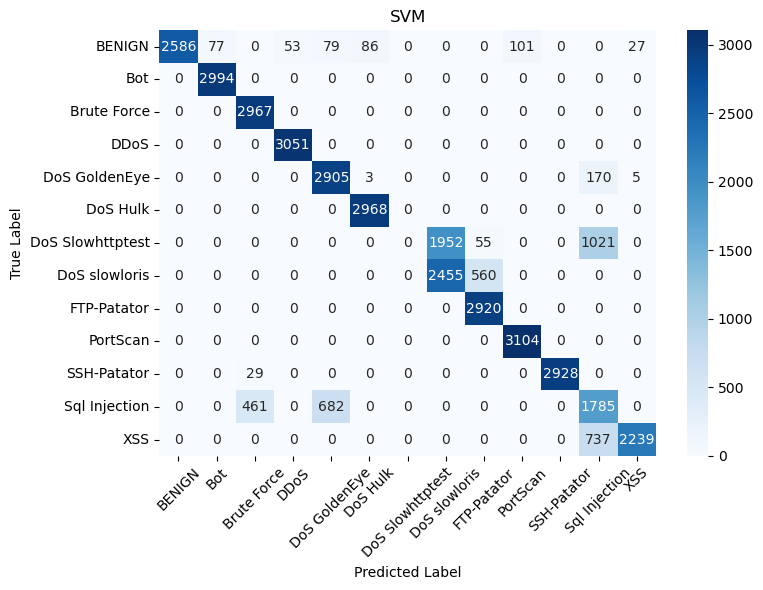

In [38]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix for SVM
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=svm_classifier.classes_, 
            yticklabels=svm_classifier.classes_)
plt.title('SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot for SVM
plt.savefig('SVM_confusion_matrix.png')

# Show plot for SVM
plt.show()


In [39]:
import lime
import lime.lime_tabular

# Initialize the LIME explainer for SVM
svm_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_top,  # Training data with top features for SVM
    feature_names=top_features,  # Top feature names for SVM
    class_names=['BENIGN', 'DDOS'],  # Class names (adjust as per your labels)
    discretize_continuous=True  # Discretize continuous features
)

# Select the observation ID you want to explain for SVM
svm_observation_id = 1  # Adjust this to the specific ID you want to explain

# Get the observation to explain for SVM
svm_observation = X_test_top[svm_observation_id].reshape(1, -1)

# Explain the model's prediction on the selected instance for SVM
svm_explanation = svm_explainer.explain_instance(
    svm_observation.flatten(),  # Instance to explain
    svm_classifier.predict_proba,  # Prediction function (SVM)
    num_features=10  # Number of features to show in explanation
)

# Show the explanation in the notebook for SVM
svm_explanation.show_in_notebook(show_table=True, show_all=False)



# VotingClassifier

In [40]:
from sklearn.ensemble import VotingClassifier

# Define the individual classifiers
dt_classifier = DecisionTreeClassifier()
rf_classifier_top = RandomForestClassifier(random_state=42)
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)  # Enable probability estimation for SVM

# List of (name, estimator) tuples for VotingClassifier
estimators = [
    ('decision_tree', dt_classifier),
    ('random_forest', rf_classifier_top ),
    ('svm', svm_classifier)
]

# Initialize the VotingClassifier
voting_classifier = VotingClassifier(estimators, voting='soft')  # You can adjust voting method as needed

# Train the VotingClassifier on the training data
voting_classifier.fit(X_train_top, y_train)

# Predict labels for the test set using the trained VotingClassifier
y_pred_voting = voting_classifier.predict(X_test_top)

# Calculate accuracy score
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("Accuracy with Voting Classifier:", accuracy_voting)

# Generate classification report for the VotingClassifier
print("Classification Report for Voting Classifier:")
print(classification_report(y_test, y_pred_voting))


Accuracy with Voting Classifier: 0.9845641025641025
Classification Report for Voting Classifier:
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00      3009
             Bot       1.00      1.00      1.00      2994
     Brute Force       1.00      1.00      1.00      2967
            DDoS       1.00      1.00      1.00      3051
   DoS GoldenEye       1.00      1.00      1.00      3083
        DoS Hulk       1.00      1.00      1.00      2968
DoS Slowhttptest       0.91      0.89      0.90      3028
   DoS slowloris       0.89      0.91      0.90      3015
     FTP-Patator       1.00      1.00      1.00      2920
        PortScan       1.00      1.00      1.00      3104
     SSH-Patator       1.00      1.00      1.00      2957
   Sql Injection       1.00      1.00      1.00      2928
             XSS       1.00      1.00      1.00      2976

        accuracy                           0.98     39000
       macro avg       0.98    

In [41]:
from sklearn.metrics import classification_report

# Generate classification report with top features
voting_report = classification_report(y_test, y_pred_voting, target_names=voting_classifier.classes_, output_dict=True)

# Print total accuracy, precision, recall, and F1-score
print("Total Accuracy:",voting_report['accuracy'])
print("Total Precision:", voting_report['macro avg']['precision'])
print("Total Recall:", voting_report['macro avg']['recall'])
print("Total F1-Score:", voting_report['macro avg']['f1-score'])


Total Accuracy: 0.9845641025641025
Total Precision: 0.9846977696090302
Total Recall: 0.984677264020311
Total F1-Score: 0.9846729315978605


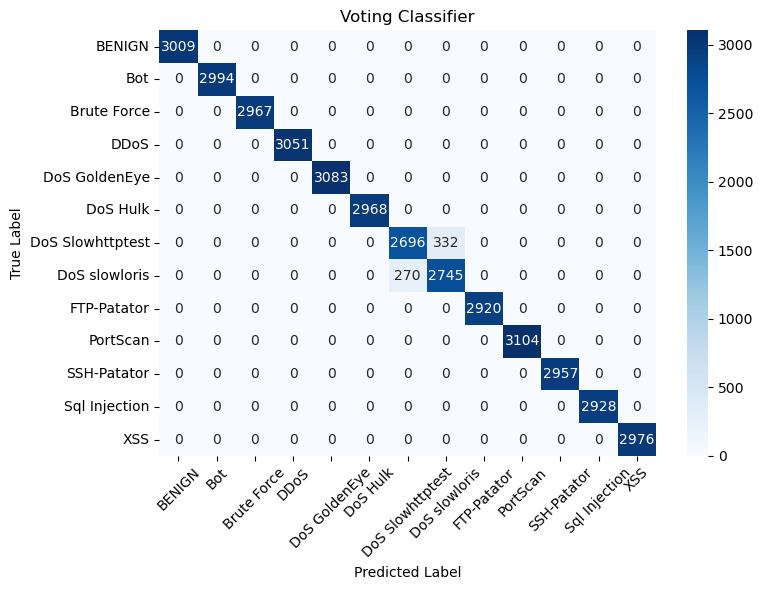

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix for Voting Classifier
conf_matrix_voting = confusion_matrix(y_test, y_pred_voting)

# Plot confusion matrix for Voting Classifier
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_voting, annot=True, fmt='d', cmap='Blues', 
            xticklabels=voting_classifier.classes_, 
            yticklabels=voting_classifier.classes_)
plt.title('Voting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot for Voting Classifier
plt.savefig('Voting_confusion_matrix.png')

# Show plot for Voting Classifier
plt.show()


In [58]:
import lime
import lime.lime_tabular

# Initialize the LIME explainer for SVM
voting_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_top,  # Training data with top features for SVM
    feature_names=top_features,  # Top feature names for SVM
    class_names=['BENIGN', 'DDOS'],  # Class names (adjust as per your labels)
    discretize_continuous=True  # Discretize continuous features
)

# Select the observation ID you want to explain for SVM
voting_observation_id = 1  # Adjust this to the specific ID you want to explain

# Get the observation to explain for voting
voting_observation = X_test_top[voting_observation_id].reshape(1, -1)

# Explain the model's prediction on the selected instance for SVM
voting_explanation = voting_explainer.explain_instance(
   voting_observation.flatten(),  # Instance to explain
    voting_classifier.predict_proba,  # Prediction function (SVM)
    num_features=10  # Number of features to show in explanation
)

# Show the explanation in the notebook for voting
voting_explanation.show_in_notebook(show_table=True, show_all=False)



In [59]:
voting_explanation.as_list()

[(' Destination Port > 0.50', 0.09972547035531411),
 (' min_seg_size_forward <= 0.21', 0.015685700770776974),
 ('0.52 < Init_Win_bytes_forward <= 0.95', 0.01256890064849673),
 ('0.00 <  Subflow Bwd Packets <= 0.00', 0.008952342882369232),
 ('0.00 < Subflow Fwd Packets <= 0.00', 0.007020477443724351),
 ('0.00 <  act_data_pkt_fwd <= 0.00', 0.006170372862254137),
 ('0.01 <  Bwd Packet Length Mean <= 0.06', 0.005763824118765446),
 ('0.00 <  Total Fwd Packets <= 0.00', -0.005144880574319947),
 ('0.48 <  Fwd Header Length <= 0.48', 0.004983202199942898),
 ('0.50 <  Fwd IAT Min <= 0.50', -0.001965645706021843)]